In [924]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [925]:
df = pd.read_csv('OnlineRetail.csv', encoding='latin1')

In [926]:
# InvoiceNo	(A unique code for each order (like a bill number)).
# StockCode	(A unique code for each product.)
# Description	(The name of the product.)	
# Quantity	(The number of units bought. )
# InvoiceDate	(The date and time of the purchase.	)
# UnitPrice	(Price for one unit (in British Pounds £).	)
# CustomerID	(A unique number for each customer. )
# Country	(The country where the customer lives.	)

In [927]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [928]:
df.shape

(541909, 8)

In [929]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [930]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [931]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [932]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [933]:
df=df[df['Quantity']>0]
df=df[~df['InvoiceNo'].str.startswith('C',na=False)]

In [934]:
df=df.dropna(subset=['CustomerID'])

In [935]:
df=df[df['UnitPrice']>0]

In [936]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [937]:
df.shape

(397884, 8)

In [938]:
df['TotalPrice']= df['UnitPrice']* df['Quantity']


In [939]:
# Recency: Days since last purchase
# Frequency: Number of purchases
# Monetary: Total money spent

In [940]:
import datetime as dt
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'  # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [941]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [942]:
rfm.shape

(4338, 3)

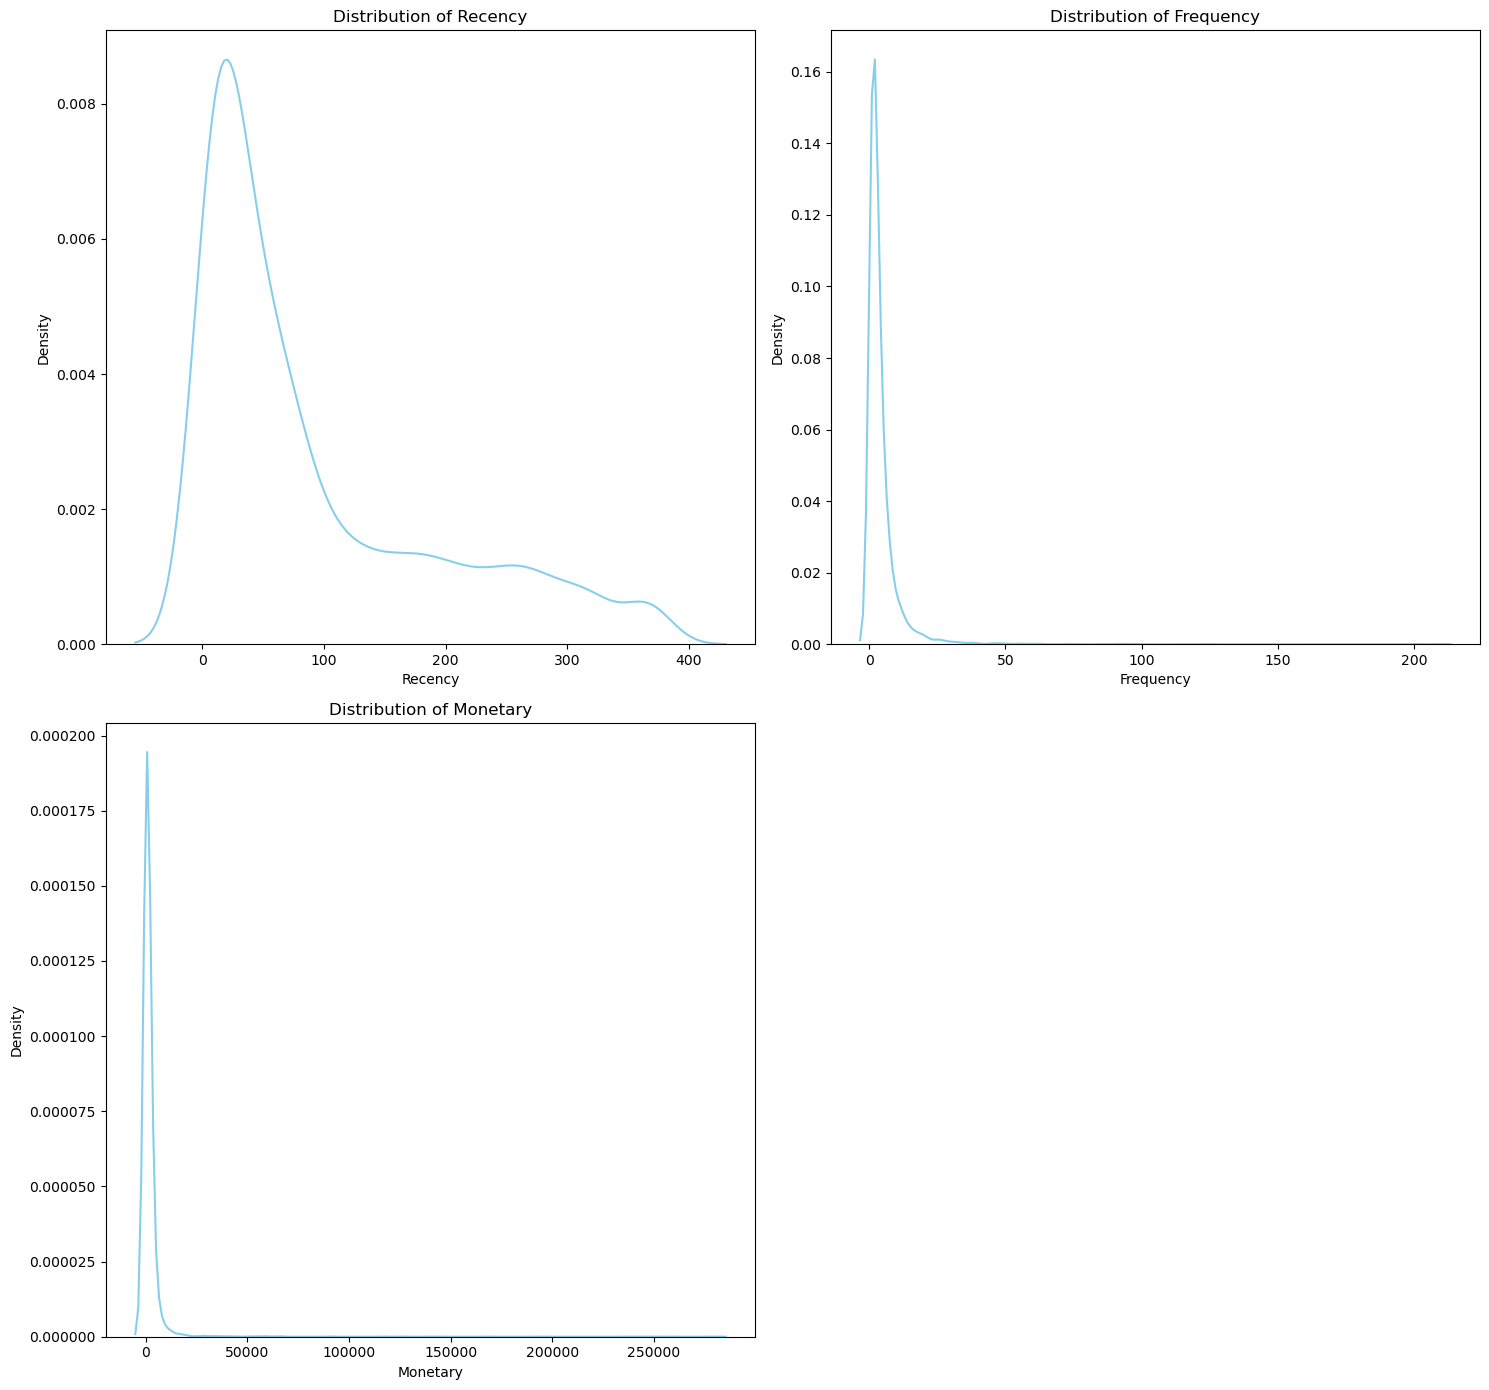

In [943]:
plt.figure(figsize=(15, 14))
plot=1
for i  in rfm.columns:
    plt.subplot(2,2,plot)
    sns.kdeplot(rfm[i], color='skyblue')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.title(f'Distribution of {i}')
    plot+=1
plt.tight_layout()
plt.show()

In [944]:
rfm['Monetary']=np.log1p(rfm['Monetary'])
rfm['Recency']=np.log1p(rfm['Recency'])
rfm['Frequency']=np.log(rfm['Frequency'])

In [945]:
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
medain=rfm['Monetary'].median()
rfm['Monetary'] = np.where(rfm['Monetary'] < lower, medain,
                           np.where(rfm['Monetary'] > upper, medain, rfm['Monetary']))
Q1 = rfm['Frequency'].quantile(0.25)
Q3 = rfm['Frequency'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
medain=rfm['Frequency'].median()
rfm['Frequency'] = np.where(rfm['Frequency'] < lower, medain,
                           np.where(rfm['Frequency'] > upper, medain, rfm['Frequency']))

In [946]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
X_scaled = pd.DataFrame(X_scaled, index=rfm.index, columns=rfm.columns)
X_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.461993,-1.060516,-0.040368
12347.0,-2.038734,1.149224,1.547802
12348.0,0.373104,0.513735,0.798604
12349.0,-0.623086,-1.060516,0.779480
12350.0,1.424558,-1.060516,-0.640256


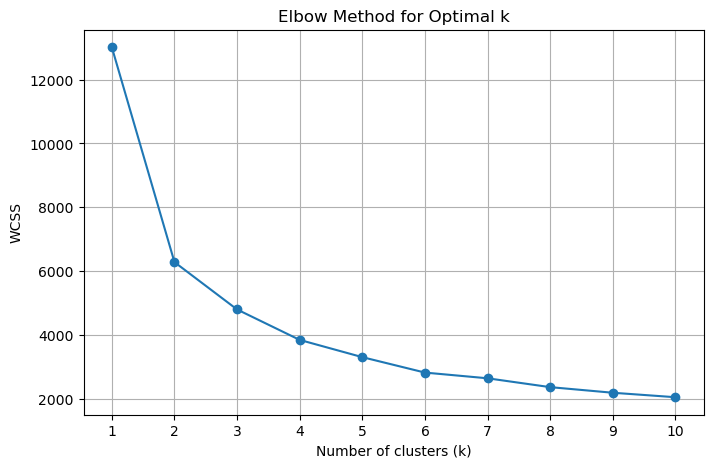

In [947]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wcss = []
# Test k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS
# Plot the Elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1,11))
plt.grid(True)
plt.show()


In [948]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
labels_km = kmeans.labels_
score_km = silhouette_score(X_scaled, labels_km)
print("K-Means Silhouette Score:", round(score_km, 4))
X_scaled['KMeans']=labels_km
rfm['KMeansCluster']=labels_km

K-Means Silhouette Score: 0.3275


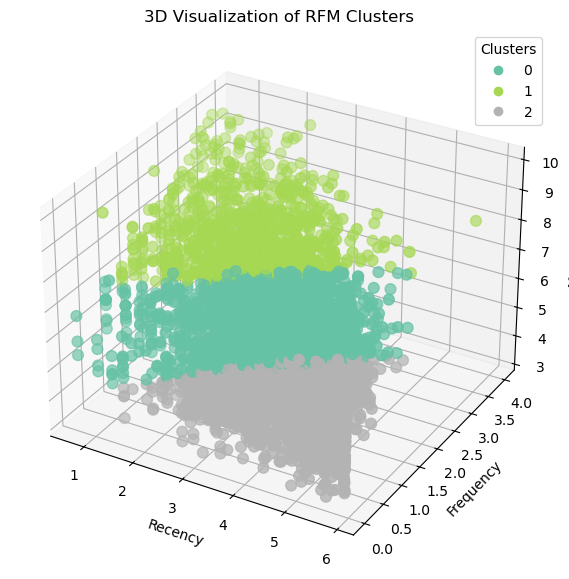

In [949]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    rfm['Recency'], 
    rfm['Frequency'], 
    rfm['Monetary'], 
    c=rfm['KMeansCluster'], 
    cmap='Set2', 
    s=60
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title("3D Visualization of RFM Clusters")
plt.legend(*sc.legend_elements(), title="Clusters")
plt.show()

In [950]:
from sklearn.cluster import DBSCAN

In [951]:
eps_values= np.linspace(0.1, 1.0, 10)
min_samples_vals= [3, 5, 7, 10]
results = []
for eps in eps_values:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled.drop('KMeans',axis=1))
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:
            sil = silhouette_score(X_scaled, labels)
        else:
            sil = np.nan
        results.append({
            'eps': round(eps,2),
            'min_samples': ms,
            'n_clusters': n_clusters,
            'silhouette': sil
        })
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(
    by='silhouette',
    ascending=False
).reset_index(drop=True)
print(df_results.head(10))

   eps  min_samples  n_clusters  silhouette
0  0.6            3           2    0.326614
1  0.6            5           2    0.324973
2  0.7            5           2    0.319092
3  0.7            7           2    0.307198
4  0.5           10           2    0.302080
5  0.7           10           3    0.287338
6  0.6           10           3    0.279340
7  0.6            7           3    0.272279
8  0.7            3           3    0.267545
9  0.5            7           3    0.244771


In [952]:
dbscam=DBSCAN(eps=0.6,min_samples=3).fit(X_scaled.drop('KMeans',axis=1))

In [953]:
labels_db = dbscam.labels_
n_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)

In [954]:
print('Number of Cluster:',n_db)
if n_db > 1:
    print("DBSCAN Silhouette Score:", round(silhouette_score(X_scaled.drop('KMeans',axis=1), labels_db), 4))
else:
    print("DBSCAN: Silhouette Score cant found.")

Number of Cluster: 2
DBSCAN Silhouette Score: 0.2888


In [955]:
DB=rfm
DB['Cluster_DB']=labels_db
X_scaled['Cluster_DB']=DB['Cluster_DB']
cluster_profile = DB.groupby('Cluster_DB').mean().round(1)
print(cluster_profile)

            Recency  Frequency  Monetary  KMeansCluster
Cluster_DB                                             
-1              3.0        1.2       7.8            0.9
 0              4.7        0.0       5.6            1.9
 1              3.4        1.4       7.1            0.6


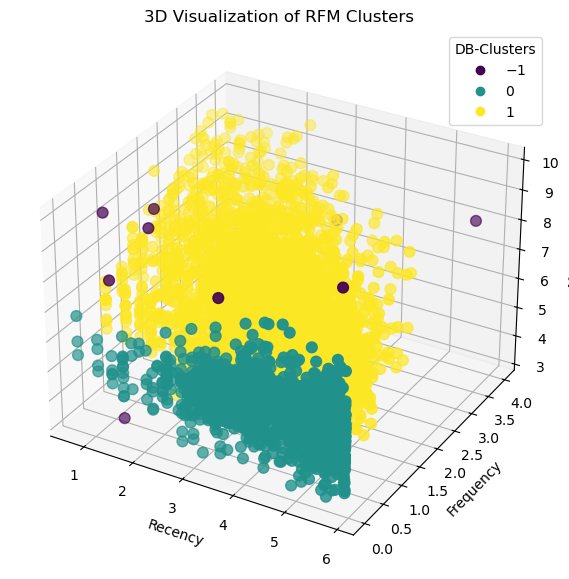

In [956]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    DB['Recency'], 
    DB['Frequency'], 
    DB['Monetary'], 
    c=DB['Cluster_DB'], 
    cmap='viridis', 
    s=60
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title("3D Visualization of RFM Clusters")
plt.legend(*sc.legend_elements(), title="DB-Clusters")
plt.show()

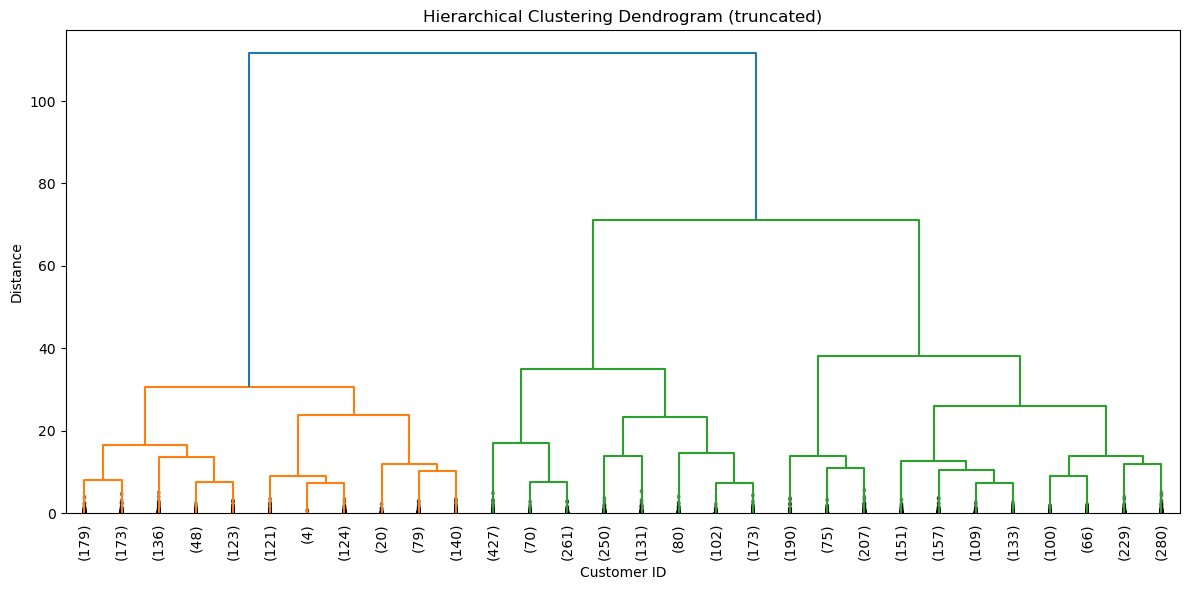

In [957]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
linked = linkage(X_scaled.drop('KMeans',axis=1), method='ward')
# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Customer ID')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [958]:
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
Hier= agglo.fit_predict(X_scaled.drop('KMeans', axis=1))
X_scaled['HierarchicalCluster']=Hier
# Add to original RFM
rfm['HierarchicalCluster'] = X_scaled['HierarchicalCluster']
# View cluster means
rfm.groupby('HierarchicalCluster').mean()


,Recency,Frequency,Monetary,KMeansCluster,Cluster_DB
HierarchicalCluster,,,,,
0,4.651957,0.001663,5.571795,1.856760,-0.002677
1,2.629947,2.068743,7.950295,0.824760,0.989538
2,4.452718,1.014520,6.590868,0.563265,1.000000
3,2.535109,0.917633,6.252646,0.076271,1.000000


In [959]:
hier_labels = rfm['HierarchicalCluster']
print("\nHierarchical Clustering Evaluation:")
print("Silhouette Score:", silhouette_score(X_scaled.drop(['KMeans', 'HierarchicalCluster'], axis=1), hier_labels))


Hierarchical Clustering Evaluation:
Silhouette Score: 0.3127855122670191


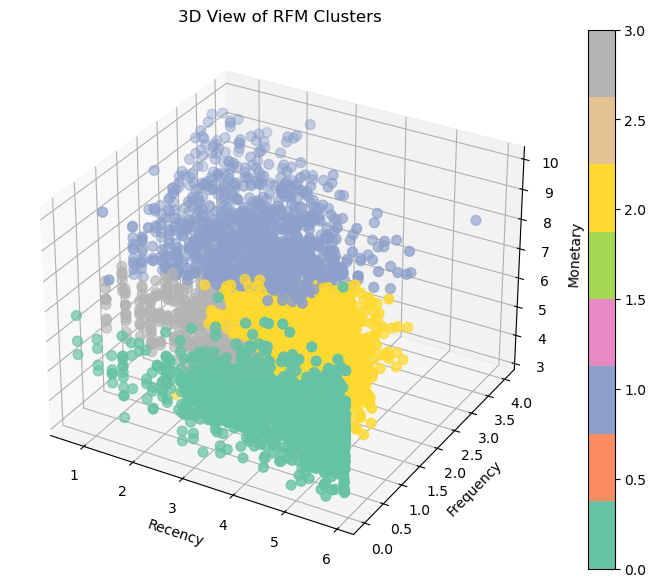

In [960]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['Recency'], 
    rfm['Frequency'], 
    rfm['Monetary'], 
    c=rfm['HierarchicalCluster'], 
    cmap='Set2', s=50
)

ax.set_title('3D View of RFM Clusters')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.colorbar(scatter)
plt.show()

In [961]:
rfm['HierarchicalCluster'].value_counts()

HierarchicalCluster
0    1494
2    1225
1    1147
3     472
Name: count, dtype: int64

In [962]:
rfm['KMeansCluster'].value_counts()

KMeansCluster
2    1742
0    1634
1     962
Name: count, dtype: int64

In [963]:
rfm['Cluster_DB'].value_counts()

Cluster_DB
 1    2838
 0    1490
-1      10
Name: count, dtype: int64

In [964]:
features = X_scaled.drop(['HierarchicalCluster','Cluster_DB','KMeans'], axis=1)
print('DB:',silhouette_score(features, labels_db))
print('KM:',silhouette_score(features, labels_km))
print('Hier:',silhouette_score(features, hier_labels))


DB: 0.28883273185552094
KM: 0.3275100848430399
Hier: 0.2646129209992436
